<a href="https://colab.research.google.com/github/SeongBaek-Cho/pubmed/blob/main/lstm_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
# from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Bidirectional, SpatialDropout1D, GRU, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers.embeddings import Embedding
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import load_model
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import regexp_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import gutenberg
from collections import Counter
import matplotlib.pyplot as plt
import json
from time import time
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
!nvidia-smi

Wed May 12 08:05:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    60W / 149W |    234MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
raw_access = []
f = open('/content/drive/Shareddrives/pool/data/train_access.txt', 'r', encoding='utf8')
for x in f.readlines():
    title, full_text = x.split('\t')
    raw_access.append([title, full_text.replace('\n', '')])
f.close()

f = open('/content/drive/Shareddrives/pool/data/train_not_access.txt', 'r', encoding='utf8')
none_raw_access = []
for x in f.readlines():
    title, full_text = x.split('\t')
    none_raw_access.append([title, full_text.replace('\n', '')])

validation_df = pd.read_excel('/content/drive/Shareddrives/pool/data/train_validationSet.xlsx', engine='openpyxl')
for abs in validation_df['Abstract'][0:150]:
    raw_access.append([None, abs])

validation_none_df = pd.read_excel('/content/drive/Shareddrives/pool/data/train_not_validationSet.xlsx', engine='openpyxl')
for abs in validation_none_df['Abstract'][0:70]:
    none_raw_access.append([None, abs])

raw = pd.DataFrame(raw_access, columns=['Title', 'Full text'])
none_raw = pd.DataFrame(none_raw_access, columns=['Title', 'Full text'])

In [ ]:
# raw = pd.read_excel('/content/drive/Shareddrives/pool/data/kw_data.xlsx', engine='openpyxl') # 연구논문
# none_raw = pd.read_excel('/content/drive/Shareddrives/pool/data/none_kw_data.xlsx', engine='openpyxl') # 비연구 논문

In [ ]:
raw['label'] = 1
raw.head(1)

,Title,Full text,label
0,31752295,"The study explores antibacterial, antiinflamma...",1


In [ ]:
none_raw['label'] = 0
none_raw.head(1)

,Title,Full text,label
0,32675189,"Blochmannia endosymbionts, belonging to Gammap...",0


In [ ]:
raw = raw.iloc[:, [1, 2]]
none_raw = none_raw.iloc[:, [1, 2]]

In [ ]:
df = pd.concat([raw, none_raw])
del raw, none_raw

In [ ]:
df = df.dropna(axis=0)
df.head()

,Full text,label
0,"The study explores antibacterial, antiinflamma...",1
1,"Ecklonia cava, an edible marine brown alga (La...",1
2,Periodontal diseases are caused by bacterial i...,1
3,"Poor oral health and related diseases, includi...",1
4,BACKGROUND: The fruit of the Terminalia chebul...,1


In [ ]:
# Compound 수 확인
df.groupby('label').size()

label
0    718
1    563
dtype: int64

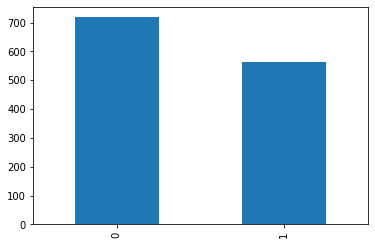

In [ ]:
df['label'].value_counts().plot(kind='bar')

In [ ]:
X, y = list(df['Full text']), list(df['label'])
df.shape

(1281, 2)

In [ ]:
X[0], len(X)

('The study explores antibacterial, antiinflammatory and cytoprotective capacity of Pelargonium sidoides DC root extract (PSRE) and proanthocyanidin fraction from PSRE (PACN) under conditions characteristic for periodontal disease. Following previous finding that PACN exerts stronger suppression of Porphyromonas gingivalis compared to the effect on commensal Streptococcus salivarius, the current work continues antibacterial investigation on Staphylococcus aureus, Staphylococcus epidermidis, Aggregatibacter actinomycetemcomitans and Escherichia coli. PSRE and PACN are also studied for their ability to prevent gingival fibroblast cell death in the presence of bacteria or bacterial lipopolysaccharide (LPS), to block LPS- or LPS + IFNgamma-induced release of inflammatory mediators, gene expression and surface antigen presentation. Both PSRE and PACN were more efficient in suppressing Staphylococcus and Aggregatibacter compared to Escherichia, prevented A. actinomycetemcomitans- and LPS-ind

In [ ]:
y[0], len(y)

(1, 1281)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

result = []
stop_words = set(stopwords.words("english"))

def lemmat(txt):
    lemm = WordNetLemmatizer()
    poss = ['a','v','n','r']
    for pos in poss:
        txt = lemm.lemmatize(txt.lower(), pos)
    return txt

for line in X:
    arr = []
    tokens = word_tokenize(line)
    for token in tokens:
        # token = token.lower()
        if token not in stop_words:
            res = re.sub("[-=+,#/?:^$.@;*\"※~&%ㆍ!』\\‘|()[]<>`'…》]", "", token)
            if len(res) > 2:
                arr.append(lemmat(res))
    result.append(arr)
X = result

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
nc = Counter(X[0])
print('surface 단어의 카운트 : {}'.format(nc['surface']))

surface 단어의 카운트 : 2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

len(X_train), len(X_test), len(y_train), len(y_test)

(1024, 257, 1024, 257)

In [ ]:
X_train[0:5], y_train[0:5]

([['the',
   'current',
   'natural',
   'history',
   'specimen',
   'databasing',
   'paradigm',
   'focus',
   'standardize',
   'occurrence',
   'data',
   'specimen',
   'collect',
   'order',
   'gather',
   'information',
   'particular',
   'specie',
   'researcher',
   'also',
   'must',
   'know',
   'encounter',
   'possibly',
   'collect',
   'specie',
   'for',
   'entomological',
   'specimen',
   'collection',
   'method',
   'terminology',
   'write',
   'label',
   'standardize',
   'perhaps',
   'however',
   'use',
   'broad-scale',
   'collection',
   'method',
   'framework',
   'may',
   'aid',
   'communication',
   'among',
   'researcher',
   'especially',
   'within',
   'context',
   'public',
   'database',
   'three',
   'main',
   'category',
   'collection',
   'method',
   'propose',
   'active',
   'human',
   'collect',
   'active',
   'specimen',
   'orientation',
   'passive',
   'specimen',
   'collection',
   'and/or',
   'concentration',
   'gener

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 15961
등장 빈도가 1번 이하인 희귀 단어의 수: 7858
단어 집합에서 희귀 단어의 비율: 49.23250422905833
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.627569216666428


In [ ]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 제한 크기 :', vocab_size)

단어 집합의 제한 크기 : 8105


In [ ]:
with open('/content/drive/Shareddrives/pool/model/best_model_vocab_size.txt', 'w', encoding='utf8') as f:
    f.write(str(vocab_size))
    f.close()

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:1])

[[2, 269, 345, 263, 873, 2319, 2858, 369, 1598, 898, 13, 873, 451, 346, 3253, 86, 482, 14, 510, 21, 1060, 167, 2859, 1160, 451, 14, 478, 5732, 873, 414, 18, 5733, 2320, 4559, 1598, 1792, 66, 3, 5734, 414, 18, 490, 57, 2321, 2105, 126, 510, 483, 145, 604, 629, 7, 160, 442, 1018, 414, 18, 210, 286, 87, 451, 286, 873, 4560, 5735, 873, 414, 874, 161, 511, 1018, 138, 364, 1, 5736, 379, 443, 183, 5732, 414, 2537, 18, 925, 2538, 215, 1061, 414, 59]]


문서의 최대 길이 : 452
문서의 평균 길이 : 136.361328125


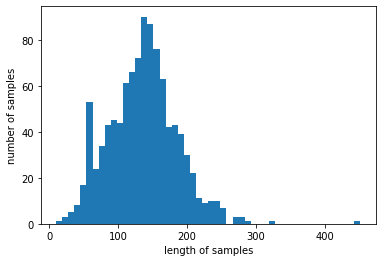

In [ ]:
max_len = max(len(l) for l in X_train)
mean_len = sum(map(len, X_train))/len(X_train)
print('문서의 최대 길이 :',max_len)
print('문서의 평균 길이 :',mean_len)
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 452 이하인 샘플의 비율: 100.0


In [ ]:
print('전체 Train 셋 : {}, 연구 : {}, 비연구 : {}'.format(len(X_train), y_train.count(1), y_train.count(0)))
print('전체 Valid 셋 : {}, 연구 : {}, 비연구 : {}'.format(len(X_test), y_test.count(1), y_test.count(0)))

전체 Train 셋 : 1024, 연구 : 450, 비연구 : 574
전체 Valid 셋 : 257, 연구 : 113, 비연구 : 144


In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
DROP_OUT = 0.2
BATCH_SIZE=32
VALIDATION_SPLIT=0.2
EPOCHS=15
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH = max_len
KERNEL_SIZE = 2
FILTERS = 32
POOL_SIZE = 2
GRU_NODE = 32
with tf.device('/gpu:0'):
    model = Sequential()
    model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True))
    # model.add(Dropout(DROP_OUT))
    model.add(GRU(32, recurrent_dropout=DROP_OUT))
    model.add(Dense(256, activation='relu'))
    # model.add(SpatialDropout1D(DROP_OUT))
    # model.add(Bidirectional(LSTM(100, dropout=DROP_OUT)))
    model.add(Dense(1, activation='sigmoid'))
    # model.add(Dropout(DROP_OUT + 0.05))
    # model.add(Conv1D(FILTERS, KERNEL_SIZE, activation='relu'))
    # model.add(MaxPooling1D(pool_size=POOL_SIZE))
    # model.add(Conv1D(FILTERS, KERNEL_SIZE, activation='relu'))
    # model.add(MaxPooling1D(pool_size=POOL_SIZE))
    # model.add(LSTM(GRU_NODE, return_sequences=True, recurrent_dropout=DROP_OUT))
    # model.add(LSTM(GRU_NODE, recurrent_dropout=DROP_OUT))
    # model.add(Dense(32,activation='relu'))
    # model.add(Dense(1))
    # model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 452, 50)           405250    
_________________________________________________________________
gru (GRU)                    (None, 32)                8064      
_________________________________________________________________
dense (Dense)                (None, 256)               8448      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 422,019
Trainable params: 422,019
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('/content/drive/Shareddrives/pool/model/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir='/content/drive/Shareddrives/pool/model/best_model_{}'.format(time()))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=EPOCHS, callbacks=[es, mc, tensorboard], batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/15
26/26 [==============================] - 56s 2s/step - loss: 0.6834 - acc: 0.5781 - val_loss: 0.6344 - val_acc: 0.5756

Epoch 00001: val_acc improved from -inf to 0.57561, saving model to /content/drive/Shareddrives/pool/model/best_model.h5
Epoch 2/15
26/26 [==============================] - 41s 2s/step - loss: 0.4834 - acc: 0.7880 - val_loss: 0.1618 - val_acc: 0.9756

Epoch 00002: val_acc improved from 0.57561 to 0.97561, saving model to /content/drive/Shareddrives/pool/model/best_model.h5
Epoch 3/15
26/26 [==============================] - 41s 2s/step - loss: 0.0428 - acc: 0.9922 - val_loss: 0.0345 - val_acc: 0.9902

Epoch 00003: val_acc improved from 0.97561 to 0.99024, saving model to /content/drive/Shareddrives/pool/model/best_model.h5
Epoch 4/15
26/26 [==============================] - 41s 2s/step - loss: 0.0146 - acc: 0.9975 - val_loss: 0.0398 - val_acc: 0.9854

Epoch 00004: val_acc did not improve from 0.99024
Epoch 5/15
26/26 [==============================] - 41s 2

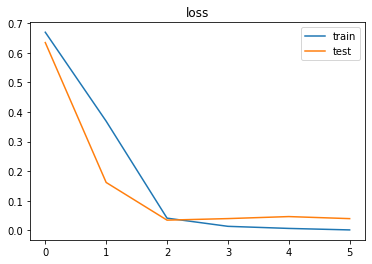

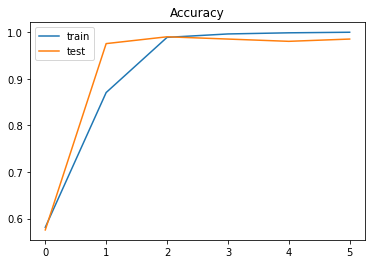

In [ ]:
plt.figure(1)
plt.title('loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.figure(2)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()

plt.show()

In [ ]:
model.save('/content/drive/Shareddrives/pool/model/best_model_last.h5')

In [ ]:
loaded_model = load_model('/content/drive/Shareddrives/pool/model/best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)[1]))

9/9 [==============================] - 2s 127ms/step - loss: 0.0722 - acc: 0.9805
테스트 정확도: 0.9805


In [ ]:
f_json = json.dumps(tokenizer.word_index)
f = open('/content/drive/Shareddrives/pool/model/best_model_tokenizer.json', 'w')
f.write(f_json)
f.flush()
f.close()

In [ ]:
np.save('/content/drive/Shareddrives/pool/model/best_model_history.npy', history.history)

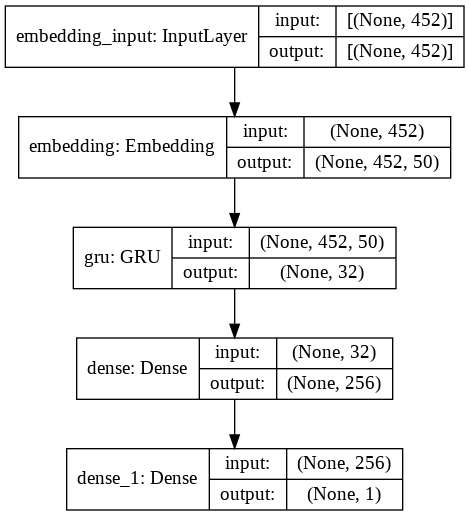

In [ ]:
plot_model(model, to_file='/content/drive/Shareddrives/pool/model/best_model_plot.png', show_shapes=True)

In [ ]:
config = {
    'max_len':max_len,
    'mean_len':mean_len,
    'batch_size': BATCH_SIZE,
    'DROP_OUT':DROP_OUT,
    'VALIDATION_SPLIT':VALIDATION_SPLIT,
    'EPOCHS':EPOCHS,
}

f = open('/content/drive/Shareddrives/pool/model/best_model_config.json', 'w', encoding='utf8')
f.write(json.dumps(config))
f.flush()
f.close()

In [ ]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r"[-=+,#/?:^$.@;*\"※~&%ㆍ!』\\‘|()[]<>`'…》]",'', new_sentence)
    arr = []
    tokens = word_tokenize(new_sentence) # tokenizer
    for token in tokens:
        if token not in stop_words: # 불용어 처리
            if len(token) > 2:
                arr.append(lemmat(token))
    encoded = tokenizer.texts_to_sequences([arr]) # int encoding
    pad_new = pad_sequences(encoded, maxlen = max_len) # padding
    print('training vocab count {} {}'.format(len(Counter(arr)), Counter(arr)))
    try: 
        score = float(loaded_model.predict(pad_new)) # prediction
        classes = loaded_model.predict_classes(pad_new)[0]
        return score, classes
    except Exception as d:
        print(d)
    
def pred_message(pred_score, classes):
    docType = ''
    if classes:
        print('{:.2f}% 확률로 {} 논문입니다.'.format(pred_score*100, '연구'))
    else:
        print('{:.2f}% 확률로 {} 논문입니다.'.format((1 - pred_score)*100, '비연구'))

def prediction(txt, type='print'):
    pred_score, classes = sentiment_predict(txt)
    if type in 'print':
        pred_message(pred_score, classes)
    else:
        return pred_score, classes

In [ ]:
def custom_prediction(txt):
    score, classes = prediction(txt, 'score')
    pred_message(score, classes)
    return classes

In [ ]:
# val_dict = {
#     '비연구1':'BACKGROUND: Toll-like receptors (TLRs) play pivotal roles in host immune responses and have been suggested to be involved in the development of many infectious diseases. In this study, the mRNA expression levels of TLR2, TLR4, and TLR9 and their relationship with periodontopathic bacteria in periodontal tissue are examined. Furthermore, the mechanism of TLR induction by Porphyromonas gingivalis is investigated in human gingival fibroblasts (HGFs). METHODS: Gingival tissue and subgingival plaque samples were collected from 19 patients with chronic periodontitis (CP) and 16 control individuals without periodontitis. Gene expression levels in the tissues and in HGFs were analyzed by reverse transcription-polymerase chain reaction (RT-PCR). The numbers of periodontopathic bacteria were determined by quantitative real-time PCR. RESULTS: The expression levels of TLR2 and TLR9 were significantly higher in the tissues of patients with CP compared to the tissues of control individuals. The mRNA levels of TLR2 and TLR9, but not TLR4, were positively correlated with the number of P. gingivalis in subgingival plaque. P. gingivalis sonicated extract, P. gingivalis lipopolysaccharide, P. gingivalis DNA, and tumor necrosis factor-alpha(TNF-alpha) could significantly upregulate the mRNA expression of TLR2 in HGFs. Furthermore, P. gingivalis-mediated TLR2 expression was suppressed by TNF-alpha antibody. CONCLUSIONS: This study suggests that P. gingivalis infection induces TLR2 and TLR9 upregulation in patients with CP. P. gingivalis-induced TLR2 expression in HGFs is partially dependent on TNF-alpha and may lead to sensitization of HGFs to bacterial components encountered in the periodontal microenvironment.',
#     '비연구2':'Drug incompatibilities can lead to loss of effectiveness of drugs or to increased risk for undesirable effects that can even be life-threatening. Especially children are at high risk. Databases are an important source of information in routine care to avoid incompatibilities. However, they were supposedly developed considering drugs for use in adults. Thus, we analysed to what extent databases are appropriate for the identification of incompatibilities in intravenous (i.v.) drug therapy in paediatric intensive care. We analysed the information provided by two databases (Database A and B) on all pairs of two drugs prescribed to be administered via the same i.v. access line in a university paediatric intensive care unit during the study period of 50 days. A total of 50 different i.v. drugs was prescribed in 318 different combinations (drug pairs). We found information on (in)compatibilities in 23.0 % (73/318) in Database A and in 31.1 % (99/318) in Database B. Only in 11.0 % (35/318) of the drug pairs, both databases provided information. Considering those drug pairs, in 17.1 % (6/35) Database B indicated compatibility whereas Database A indicated incompatibility. Compatibility information delivered by databases on drugs used in paediatric intensive care is incomplete, heterogeneous, and partly contradictory. Thus, an increased awareness on the strengths and limitations of different databases is necessary to avoid patient harm.',
#     '비연구3':'The contribution that the Chemical Abstracts structural database (CAST-3D) and the Maybridge database (MAY) would make to diversifying the structural information and property space spanned by our corporate database (CBI) is assessed. A subset of the CAST-3D database has been selected to augment the structural diversity of various electronic databases used in computer-assisted drug design projects. The analysis of the MAY database directly offers the potential to expand the CBI compound library, but also provides a source for structural diversity in a format suitable for computer-assisted database searching and molecular design. The analysis performed is twofold. First, a nonhierarchical clustering technique available in the Daylight clustering package is applied to evaluate the structural differences between databases. The comparison is then extended to analyze various structure-derived property spaces calculated from molecular descriptors such as the logarithm of the octanol-water partition coefficient (CLOGP), the molar refractivity (CMR) and the electronic dipole moment (CDM). The diversity contribution of each database to these property spaces is quantified in relation to our corporate database.',
#     '비연구4':'A protein class (ProClass) database is developed as a "value-added" "second-generation" database organized according to family relationships. The database collects non-redundant protein sequence entries from SwissProt and PIR databases, and classifies them in families defined collectively by the ProSite protein groups and PIR superfamilies. The major objectives of the database are to maximize family information retrieval, to provide speedy family identification, and to help organizing existing protein sequence databases. The database has two sub-databases: PCFam (ProClass Family) to define protein families and provide links to ProSite patterns and PIR superfamilies, and PCSeq (ProClass Sequence) to describe sequence entries and provide links to PCFam, SwissProt, PIR, and ProSite databases. The current ProClass release has a total of 85,165 sequence entries, about half of which are classified in 3072 ProClass families; it also contains 10,431 newly established SwissProt-PIR links. The database can help reveal domain structures of related families, define new ProSite and PIR families, and provide family assignments for unclassified sequence entries. New ProSite and PIR family members are readily identified via database cross-reference, including 9437 SwissProt entries and 8522 PIR entries. False negative family members missed by both ProSite and PIR are detected using a neural network family identification system. The newly identified superfamily memberships are being incorporated into the current PIR database releases in a collaborative effort with the PIR. The ProClass database is accessible through anonymous FTP and on-line search on the World Wide Web.',
#     '비연구5':'Background: Breast cancer is the most commonly diagnosed noncutaneous malignancy and remains the second leading cause of cancer deaths in women. The Savi Scout (Cianna Medical, Merit Medical Systems, Inc. South Jordan, UT) is a wireless, nonradioactive, wave reflection implant system that enables surgeons to remove targeted breast lesions. Our study aims to be the largest comparison of wire and Savi Scout localization techniques for positive margin, complication, and reoperation rates. Methods: Single-institution retrospective review of 512 patients that had Savi Scout Surgical Guidance System breast lesion biopsy or wire localized breast biopsy from May 2017 to December 2018. A RedCaps database was created and reviewed for outcomes. Results: For 320 Savi scout patients, margins were positive or less than 1 mm in 18 cases (5.6%). 17 (5.3%) patients required reoperation. Surgical site occurrence was found in 7 (2.1%) patients, and 2 patients required intervention (0.6%). For 175 wire localization patients, margins were positive or less than 1 mm in 24 patients, and all required reoperation (13.7%). A surgical site occurrence was found in 13 (7.4%) patients and 5 patients required intervention (2.8%). Discussion: In our series, the Savi Scout localization system resulted in a lower rate of positive margins, reoperation, and surgical site occurrence. These data suggest that Savi Scout localization is a reasonable replacement to wire localization for breast lesions and might produce superior results.',
#     '연구1':'Retinal endothelial cells (RECs) are involved in many ocular diseases such as age-related macular degeneration (AMD) and diabetic retinopathy. Salicin is the major ingredient of willow bark extract, and it has been shown to be a potent anti-inflammatory agent. We aim to explore whether salicin has a vascular protective effect in RECs. Our data indicate that the presence of salicin in RECs culture media ameliorates interleukin-1β (IL-1β)-induced cellular reactive oxygen species (ROS) production and NADPH oxidase 4 (NOX-4) expression. At the cellular level, salicin attenuates IL-1β-induced mitochondrial injury as revealed by its preservation on mitochondrial membrane potential (MMP). Furthermore, salicin inhibits IL-1β-induced production of pro-inflammatory cytokines such as tumor necrosis factor-α (TNF-α), interleukin-6 (IL-6), and monocyte chemoattractant protein-1 (MCP-1), vascular adhesion molecules such as intercellular cell adhesion molecule-1 (iCAM-1) and vascular cell adhesion molecule 1 (VCAM-1), and high-mobility group protein 1 (HMGB-1). On the other hand, salicin recovers IL-1β-induced reduction of endothelial nitric oxide synthase (eNOS) and nitric oxide (NO) release. The presence of salicin significantly reduces the IL-1β-induced release of lactate dehydrogenase (LDH), indicating that it mitigates cytokine caused cytotoxicity. Mechanistically, we show that salicin suppresses IL-1β-induced activation of the nuclear factor-kappa B (NF-κB) signaling as revealed by its suppression on nuclear p65 protein and transfected NF-κB promoter. Collectively, our study demonstrates by multiple facets of its mechanisms that salicin is a protective agent in retinal endothelial cells. These results imply its potential use in therapeutic usage of retinal disease.',
#     '연구2':'Some studies have demonstrated that ascorbic acid, similarly to ketamine, exhibits antidepressant-like effects mediated, at least in part, by modulation of the glutamatergic system. Despite the involvement of glutamatergic system in the pathophysiology of anxiety disorders, the ability of ascorbic acid and ketamine to elicit anxiolytic effects in animal models remains to be established. Therefore, this study investigated the effects of a single administration of ascorbic acid, ketamine or diazepam (positive control) in different animal models of anxiety. Mice were treated with ascorbic acid (1, 3 and 10 mg∕kg, p.o.), ketamine (1 and 10 mg∕kg, i.p.) or diazepam (2 mg∕kg, p.o) and their behavioral responses were assessed in the elevated plus maze, open field test (OFT), ligh∕dark preference test and marble burying test. Ascorbic acid increased total time spent in the open arms of elevated plus maze, increased total time in the center of the OFT, decreased rearing responses, increased the latency to grooming, decreased the rostral grooming, but did not affect body grooming. Furthermore, ascorbic acid increased the latency time and total time in light area in the ligh∕dark preference test, but did not affect the performance of mice in the marble burying test. Ketamine demonstrated an anxiolytic-like effect in elevated plus maze, OFT, and ligh∕dark preference test. Diazepam exhibited an anxiolytic-like effect in all the behavioral tests. Altogether, the results indicate the potential anxiolytic effect of ascorbic acid and ketamine, providing a possible new avenue for the management of anxiety-related disorders.',
# }
# for key, value in zip(val_dict.keys(), val_dict.values()):
#     custom_prediction(value)

suc_cnt, no_cnt = 0, 0
for abstract in validation_df['Abstract'][150:]:
    classes = custom_prediction(abstract)
    if classes == [1]:
        suc_cnt += 1
    else:
        no_cnt += 1

training vocab count 93 Counter({'surface': 7, 'implant': 6, 'vivo': 5, 'quercitrin': 5, 'vitro': 4, 'expression': 4, 'cell': 3, 'relate': 3, 'bone': 3, 'effect': 2, 'osteoclast': 2, 'activity': 2, 'titanium': 2, 'coat': 2, 'evaluate': 2, 'osteoclastogenesis': 2, 'rankl': 2, 'phosphatase': 2, 'trap': 2, 'day': 2, 'culture': 2, 'mrna': 2, 'level': 2, 'marker': 2, 'resorption': 2, 'use': 2, 'wind': 2, 'fluid': 2, 'moreover': 2, 'decrease': 2, 'ctsk': 2, 'h⁺atpase': 2, 'mmp9': 2, 'study': 1, 'covalently': 1, 'flavonoid': 1, 'the': 1, 'first': 1, 'test': 1, 'raw264.7': 1, 'supplement': 1, 'receptor': 1, 'activator': 1, 'nuclear': 1, 'factor': 1, 'kappa-b': 1, 'ligand': 1, 'generate': 1, 'osteoclast-like': 1, 'tartrate-resistant': 1, 'acid': 1, 'inmunostaining': 1, 'five': 1, 'analysis': 1, 'seven': 1, 'rabbit': 1, 'tibial': 1, 'model': 1, 'biological': 1, 'response': 1, 'eight': 1, 'week': 1, 'heal': 1, 'analyze': 1, 'lactate': 1, 'dehydrogenase': 1, 'ldh': 1, 'alkaline': 1, 'alp': 1, 'pre

In [ ]:
print(suc_cnt, no_cnt, suc_cnt/(suc_cnt+no_cnt))

93 9 0.9117647058823529


In [ ]:
suc_cnt, no_cnt = 0, 0
for abstract in validation_none_df['Abstract'][70:]:
    classes = custom_prediction(abstract)
    if classes != [1]:
        suc_cnt += 1
    else:
        no_cnt += 1

training vocab count 106 Counter({'child': 15, 'dmtp': 7, 'concentration': 7, 'pesticide': 5, 'seattle': 5, 'farmworker': 5, 'exposure': 5, 'high': 4, 'dmap': 3, 'live': 3, 'period': 3, 'sample': 3, 'study': 2, 'group': 2, 'applicator': 2, 'metabolite': 2, 'level': 2, 'median': 2, 'μg/l': 2, 'agricultural': 2, 'community': 2, 'elevate': 2, 'respectively': 2, 'health': 2, 'worker': 2, 'time': 2, 'examine': 1, 'find': 1, 'five': 1, 'organophosphorus': 1, 'biomonitoring': 1, 'conduct': 1, 'washington': 1, 'state': 1, '1994': 1, '1999': 1, 'compare': 1, 'urinary': 1, 'dimethylthiophosphate': 1, 'composite': 1, 'dimethyl': 1, 'alkylphosphate': 1, 'select': 1, 'substantially': 1, '0.0001': 1, 'crop': 1, 'spray': 1, 'differ': 1, 'significantly': 1, '6.1': 1, '5.8': 1, '0.73': 1, 'however': 1, '117': 1, 'nmol/l': 1, '0.007': 1, 'u.s.': 1, '6–11': 1, 'year': 1, 'age': 1, '1999–2000': 1, 'national': 1, 'nutrition': 1, 'examination': 1, 'survey': 1, 'population': 1, '75th': 1, '90th': 1, '95th': 

In [ ]:
print(suc_cnt, no_cnt, suc_cnt/(suc_cnt+no_cnt))

100 0 1.0
